In [53]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

nnodes = 107  # nodes

# Horizon for each problem
ndays = 'full'
n_int_steps = 1

setup = ItalySetup(nnodes, ndays)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}.pkl', 'rb') as inp:
    p = pickle.load(inp)


Loaded Italy Setup with 107 nodes.


In [55]:
mydata = pd.read_csv('model_output/20201129new-int107-r0-m0.csv', index_col= 'date', parse_dates=True, )

In [61]:
mydata = pd.read_csv('model_output/20201129-int107-r4000-m30000000.csv', index_col= 'date', parse_dates=True, )

In [56]:
myopt = pd.read_csv('model_output/20201129-opt107-r0-m0.csv', index_col= 'date', parse_dates=True, )

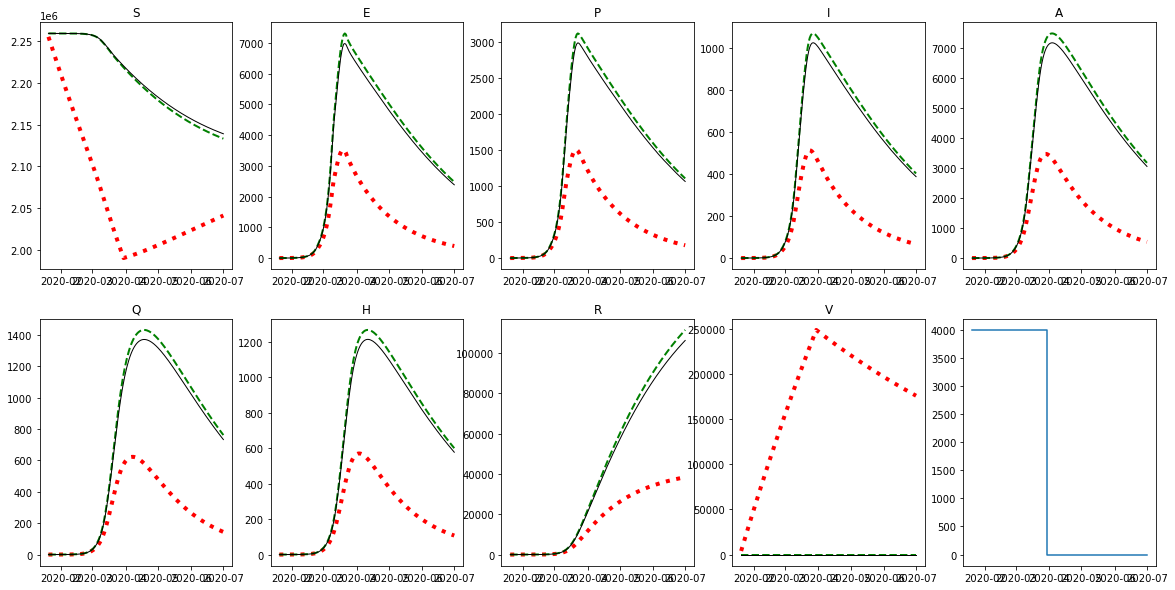

In [62]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 0

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");

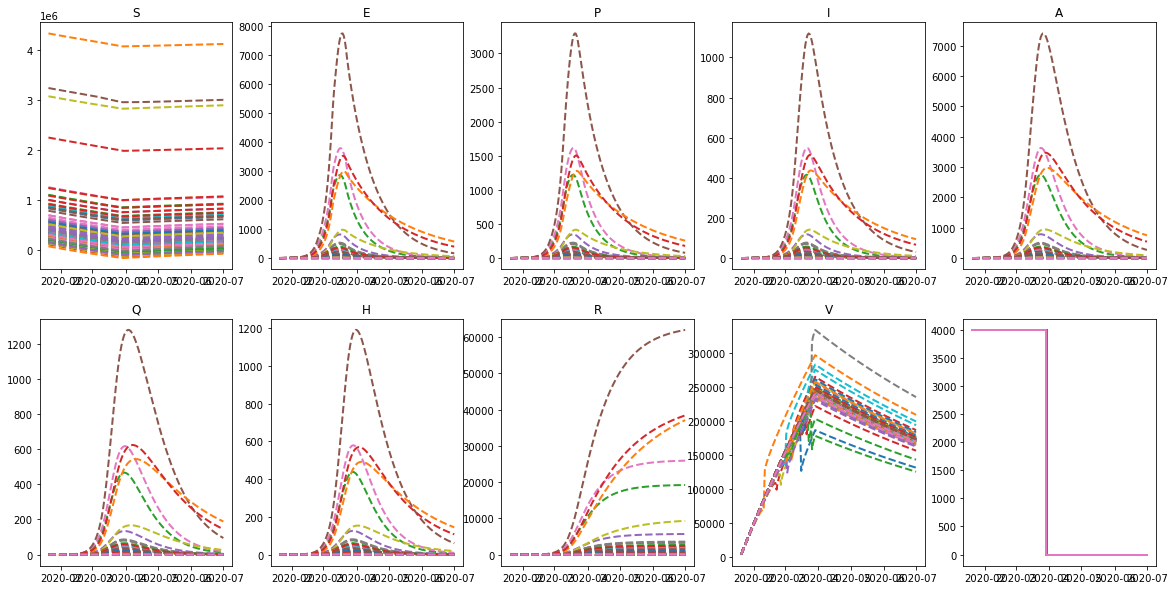

In [64]:
fig, axes = plt.subplots(2,5, figsize = (20,10))

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '--')
    #for k in range(M):
    #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);

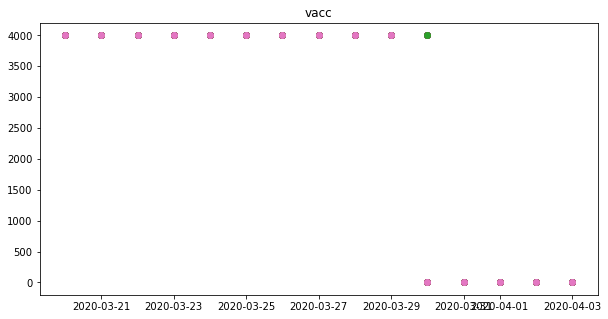

In [79]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'

ax.plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values='value').iloc[60:75], lw = 2, ls = '', marker='o')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st);


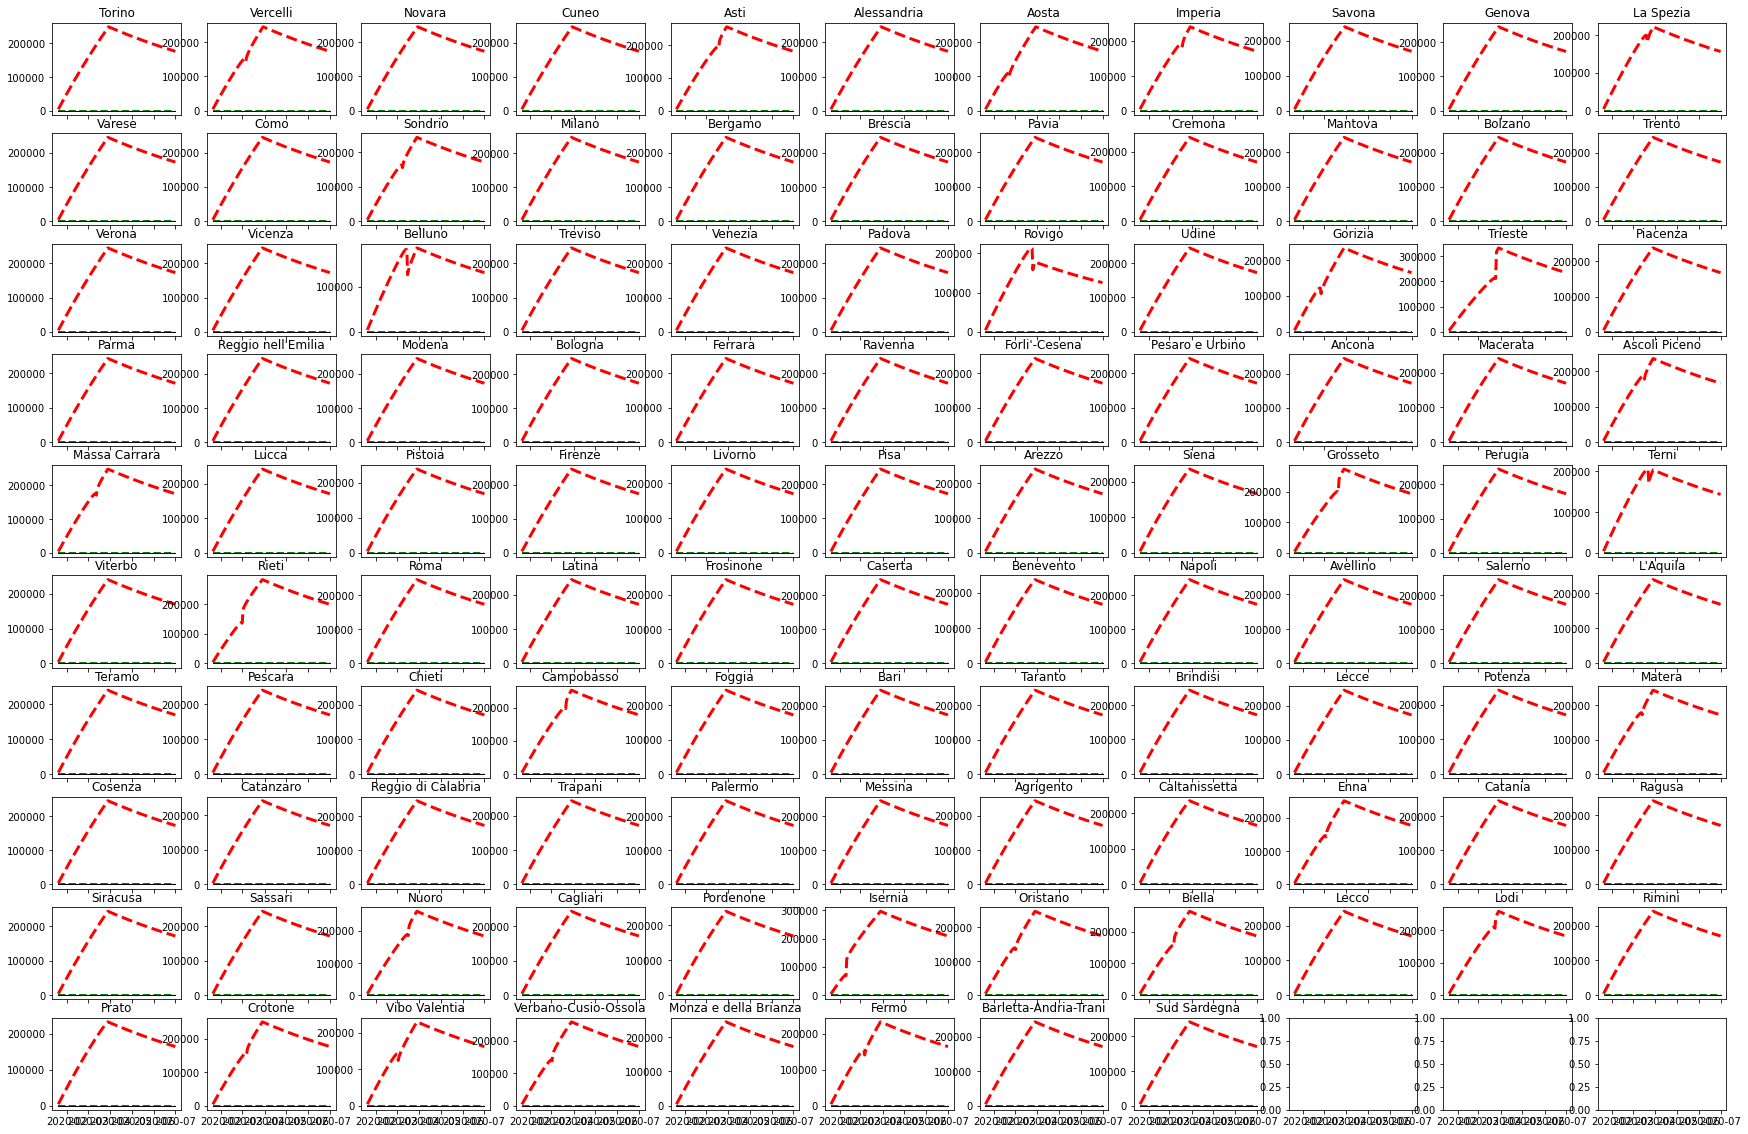

In [65]:
fig, axes = plt.subplots(10,11, figsize = (30,20), sharex=True, facecolor = 'white')#, sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 8
st = states_names[i]
for k, nname in enumerate(setup.ind2name):
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='--', lw = 3, color='r')
    axes.flat[k].plot(myopt[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='--', lw = 2, color='g')
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
    

In [8]:
G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
setup.shp['vacc'] = np.nan
setup.shp['Rend'] = np.nan
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node[i]
    #G.comp[node] = (ocp.ic['S'][i], ocp.ic['I'][i],ocp.ic['R'][i])
    try:
        G.epi[node] = {'vacc': sum(np.array(ca.veccat(ca.veccat(*opt['u',i,:,'v']))))[0],
                   'Rend':                            float(opt['x',i,-1,'R'])}
        s.shp.loc[i, 'vacc'] = sum(np.array(ca.veccat(ca.veccat(*opt['u',i,:,'v']))))[0]
        s.shp.loc[i, 'Rend'] = float(opt['x',i,-1,'R'])
    except NameError as e:
        #print(f'epi data failed, {e}')
        G.epi[node] = {'vacc': np.nan,
                   'Rend':     np.nan}
        setup.shp.loc[i, 'vacc'] = np.nan
        setup.shp.loc[i, 'Rend'] = np.nan
        
    setup.shp.loc[i, 'population'] =  setup.pop_node[i] # overwrite 
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection)
G.number_of_edges()

25

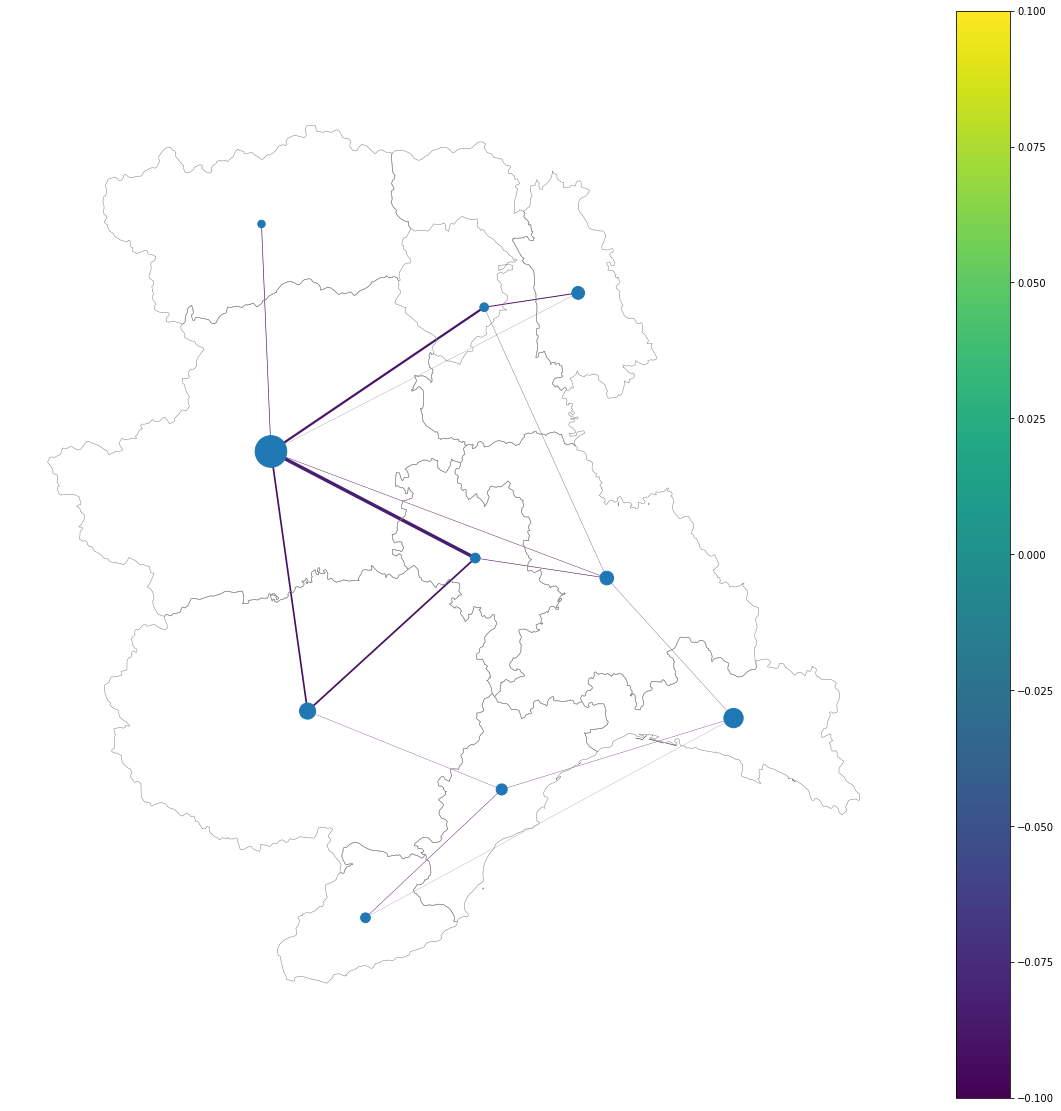

In [9]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))


networkx.draw(G, 
         G.position, 
         node_size=1000/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          #node_color=[float(G.degree(v)) for v in G],
        #node_color=[G.population[v] for v in G],
          #node_color=[G.epi[v]['vacc']/G.population[v] for v in G],
          #node_color= [G.epi[v]['vacc'] for v in G],
          width = 40* np.array([max(a['weight'],0.003) for u,v,a in G.edges(data=True)]),
          edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
          edge_cmap = mpl.cm.viridis,
          ax = ax,
         with_labels=False
       )

#     # scale the axes equally
#plt.xlim(min(s.pos_node[:,0]) - 100000, max(s.pos_node[:,0])+ 100000)
#plt.ylim(min(s.pos_node[:,1]) - 100000, max(s.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="grey", linewidth = .5)


cmap= mpl.cm.viridis
vmin = min([G.epi[v]['vacc'] for v in G])
vmax = max([G.epi[v]['vacc'] for v in G])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
plt.colorbar(sm)

plt.draw()

<AxesSubplot:>

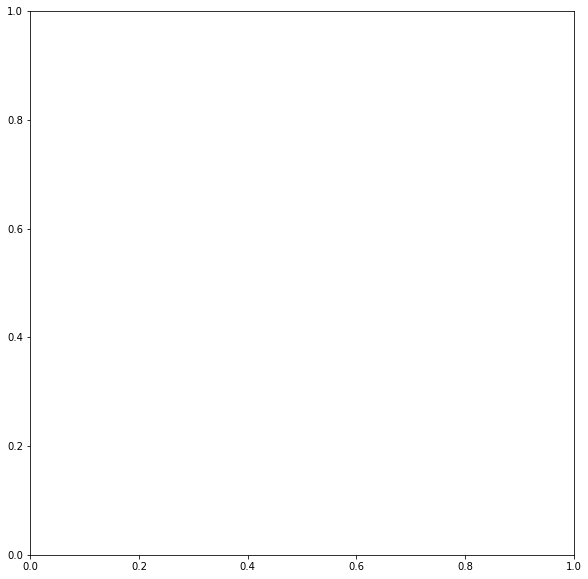

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
setup.shp.plot(ax = ax, column='vacc', cmap='OrRd',  edgecolor="black") #facecolor="none",

(0.0, 0.0002)

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/matplotlib/colors.py:1012: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


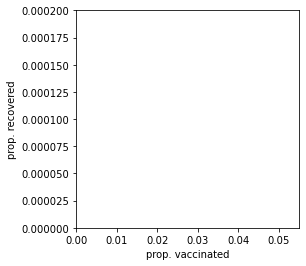

In [11]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['vacc']/setup.shp['population'], setup.shp['Rend']/setup.shp['population'], c= setup.shp['population'])
ax.set_xlabel("prop. vaccinated")
ax.set_ylabel("prop. recovered");
ax.set_xlim(0)
ax.set_ylim(0, 0.0002)

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='population'>

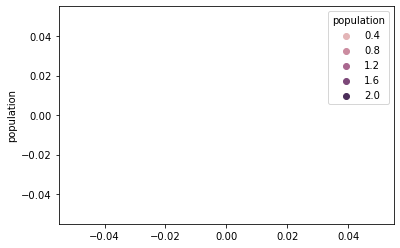

In [12]:
sns.scatterplot(setup.shp['vacc'], setup.shp['population']*100, hue= setup.shp['population'])

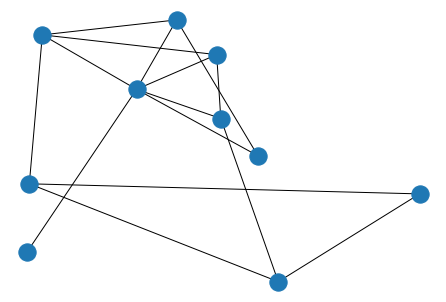

In [13]:
grph = networkx.from_numpy_matrix(p.mobmat_pr)
networkx.draw(grph)